In [1]:
from legal_backend.r_to_py.r_to_py import init_R
from legal_backend.bartCause.bart_cause import BARTCause
from legal_backend.pip_utils import prepare_train_data, rmse, nrmse, r_square, coverage_rate, kfold_indices, prepare_permute_data, statistic

import pandas as pd
import numpy as np
from sklearn import preprocessing

from scipy.stats import permutation_test
from matplotlib import pyplot as plt
from scipy import stats
from collections import Counter



In [2]:
init_R()

### Infer Law Effect

In [3]:
#load csv files and load possible laws
df = pd.read_csv('data/goodsam_all.csv')

In [4]:
df.rename(columns={'death-rate-2013-2016':'delta_death_rate'}, inplace=True)
df['Urbanicity'] = df['Urbanicity'].map({'Urban':1, 'Rural':0})
df.columns

Index(['Percent-of-Population-Under-15-(2013-2017)',
       'Percent-of-Population-Aged-15-to-64-(2013-2017)',
       'Percent-of-Population-65+-(2013-2017)',
       'Percent-of-Population-White-(non-Hispanic)-(2013-2017)',
       'Percent-of-Populaiton-Black-(non-Hispanic)-(2013-2017)',
       'Percent-of-Population-Hispanic-or-Latino-(2013-2017)',
       'Percent-of-Population-Asian-(non-Hispanic)-(2013-2017)',
       'Percent-of-Population-Native-American/Alaska-Native-(non-Hispanic)-(2013-2017)',
       'Percent-of-Population-Native-Hawaiian/Pacific-Islander-(2013-2017)',
       'Percent-of-Population-Aged-25+-who-Have-at-Least-a-High-School-Diploma-(2013-2017)',
       'Percent-of-Population-Aged-25+-who-Have-a-Bachelor's-Degree-or-More-(2013-2017)',
       'Poverty-Rate-(2013-2017)', 'Median-Household-Income-(2013-2017)',
       'Unemployment-Rate-(2013-2017)',
       'Percent-of-Residents-with-a-Disability-(Aged-18-64)-(2013-2017)',
       'Percent-of-Popualtion-Employed-in-Mini

In [30]:
from scipy.stats import percentileofscore
percentileofscore(df['Percent-of-Populaiton-Black-(non-Hispanic)-(2013-2017)'], 0.004)

17.739878865157795

In [27]:
np.percentile(df['Percent-of-Popualtion-Employed-in-Mining-and-Natural-Resources-(2013-2017)'], 32)

0.0086

###  Patterns

In [5]:
df_sub = df.copy(deep=True)
"df_sub['Urbanicity']==1"
"df_sub['Percent-of-Population-Under-15-(2013-2017)']>0.216"
"df_sub['Percent-of-Popualtion-Employed-in-Mining-and-Natural-Resources-(2013-2017)']<0.009"
# df_sub = df_sub[df_sub['Percent-of-Population-Aged-25+-who-Have-a-Bachelor\'s-Degree-or-More-(2013-2017)']>0.221].reset_index(drop=True)
# df_sub = df_sub[df_sub['Percent-of-Residents-with-a-Disability-(Aged-18-64)-(2013-2017)']<0.116].reset_index(drop=True)
"df_sub['Percent-of-Population-Aged-15-to-64-(2013-2017)']>0.631"
"df_sub['Percent-of-Population-Native-Hawaiian/Pacific-Islander-(2013-2017)']<0.001"
"df_sub['Number-of-Mental-Health-Facilities-(As-of-March-2023)']>2"
"df_sub['Economic-Risk-Score']==2"
"df_sub['Percent-of-Population-Native-American/Alaska-Native-(non-Hispanic)-(2013-2017)']<0.002"
"df_sub['Percent-of-Populaiton-Black-(non-Hispanic)-(2013-2017)']<0.004"
"df_sub['Number-of-Substance-Use-Facilities-(As-of-March-2023)']>2"
"df_sub['MDsPerCapita']>9.17"

"df_sub['MDsPerCapita']>9.17"

In [6]:
conds = []
conds.append("df_sub['Percent-of-Popualtion-Employed-in-Mining-and-Natural-Resources-(2013-2017)']<0.009")
conds.append("df_sub['Percent-of-Populaiton-Black-(non-Hispanic)-(2013-2017)']>0.004")
conds.append("df_sub['Percent-of-Populaiton-Black-(non-Hispanic)-(2013-2017)']<0.307")
for cond in conds:
    df_sub = df_sub.loc[eval(cond)].reset_index(drop=True)
law = 'goodsam-cs_Prosecution'

In [7]:
print(law)
print(df_sub.shape[0])
df_sub.head()

goodsam-cs_Prosecution
843


,Percent-of-Population-Under-15-(2013-2017),Percent-of-Population-Aged-15-to-64-(2013-2017),Percent-of-Population-65+-(2013-2017),Percent-of-Population-White-(non-Hispanic)-(2013-2017),Percent-of-Populaiton-Black-(non-Hispanic)-(2013-2017),Percent-of-Population-Hispanic-or-Latino-(2013-2017),Percent-of-Population-Asian-(non-Hispanic)-(2013-2017),Percent-of-Population-Native-American/Alaska-Native-(non-Hispanic)-(2013-2017),Percent-of-Population-Native-Hawaiian/Pacific-Islander-(2013-2017),Percent-of-Population-Aged-25+-who-Have-at-Least-a-High-School-Diploma-(2013-2017),...,goodsam-paroleyn,goodsam-parole_Protection from arrest,goodsam-parole_Protection from charge,goodsam-parole_Protection from prosecution,goodsam-parole_Protection from revocation of probation and/or parole,goodsam-parole_General protection from sanctions for violation of probation and/or parole,goodsam-mitigation,goodsam-mit-type_Controlled substances offenses,goodsam-mit-type_Alcohol-related offenses,goodsam-mit-type_Other offenses beyond controlled substances and alcohol-related violations
0,0.1942,0.6339,0.1719,0.8766,0.0156,0.0873,0.0016,0.0030,0.0000,0.8003,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.1813,0.6594,0.1593,0.7300,0.2033,0.0344,0.0093,0.0020,0.0001,0.8234,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.1769,0.6386,0.1845,0.7885,0.1565,0.0240,0.0042,0.0060,0.0006,0.8342,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.1958,0.6499,0.1543,0.7019,0.1940,0.0589,0.0102,0.0058,0.0002,0.8583,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.1791,0.6473,0.1736,0.7843,0.1528,0.0363,0.0068,0.0040,0.0006,0.8245,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
print(Counter(df_sub[law]))
num_instances = list(Counter(df_sub[law]).values())
imbalance_ratio = min(num_instances) / max(num_instances)
print("Imbalanced Data Detected! Imbalnce Ratio:", imbalance_ratio) if (imbalance_ratio < 0.1) else None

Counter({1.0: 599, 0.0: 244})


In [9]:
X_train_scaled, y_train, Z_train, X_test_scaled, y_test, Z_test = prepare_train_data(df_sub, law)

In [10]:
bart_eval = BARTCause()
bart_eval.fit(X_train_scaled, y_train, Z_train, n_samples=1000,  n_burn=200,  n_chains=5)

In [11]:
# evaluate BART fit on response surface
newData = np.concatenate((X_test_scaled, Z_test), axis=1)

y_test_predicted_, y_test_predicted_lb, y_test_predicted_ub = bart_eval.predict(newData, infer_type="mu")

# y_test_predicted_ = bart_eval.predict(newData, infer_type="mu")
y_test_predicted = y_test_predicted_[:,np.newaxis]
y_test_predicted_lb = y_test_predicted_lb[:,np.newaxis]
y_test_predicted_ub = y_test_predicted_ub[:,np.newaxis]

In [12]:
print("quantile(0.05-0.95): [",np.quantile(y_test, 0.05),",", np.quantile(y_test, 0.95),"]")
print("BART RMS:", rmse(y_test,y_test_predicted),"\n", "Baseline RMS:", rmse(y_test,y_test.mean()))
print("r square:", r_square(y_test,y_test_predicted), "\n", "nrmse:", nrmse(y_test, y_test_predicted, 'range'))
print("coverage rate:", coverage_rate(y_test, y_test_predicted_lb, y_test_predicted_ub))

quantile(0.05-0.95): [ 11.781299542827616 , 127.42743961736396 ]
BART RMS: 35.56062420117145 
 Baseline RMS: 43.17957642401473
r square: 0.32176219186890054 
 nrmse: 0.10287347880807751
coverage rate: 0.6449704142011834


In [13]:
print("quantile(0.05-0.95): [",np.quantile(y_test, 0.05),",", np.quantile(y_test, 0.95),"]")
print("BART RMS:", rmse(y_test,y_test_predicted),"\n", "Baseline RMS:", rmse(y_test,y_test.mean()))
print("r square:", r_square(y_test,y_test_predicted), "\n", "nrmse:", nrmse(y_test, y_test_predicted, 'range'))
print("coverage rate:", coverage_rate(y_test, y_test_predicted_lb, y_test_predicted_ub))

quantile(0.05-0.95): [ 11.781299542827616 , 127.42743961736396 ]
BART RMS: 35.56062420117145 
 Baseline RMS: 43.17957642401473
r square: 0.32176219186890054 
 nrmse: 0.10287347880807751
coverage rate: 0.6449704142011834


#### K-fold Cross Validation

In [14]:
fold_indices = kfold_indices(df_sub, 5)

In [15]:
def cross_validation_test(df, law, fold_indices):
    bartCause = BARTCause()
    
    X_df = df.iloc[:, :27].to_numpy()
    M = X_df.shape[1] 

    y = df[['delta_death_rate']].to_numpy()
    Z_law = df[[law]].to_numpy()
    # numerical columns
    num_cols = [c for c in range(M) if len(np.unique(X_df[:, c])) > 2] 

    scores = []

    for fold, (train_indices, test_indices) in enumerate(fold_indices):
        print("fold:",fold)
        X_train, y_train, Z_train = X_df[train_indices,:], y[train_indices,:], Z_law[train_indices,:]
        X_test, y_test, Z_test = X_df[test_indices,:], y[test_indices,:], Z_law[test_indices,:]

        # standardize data
        scaler_ = preprocessing.StandardScaler().fit(X_train[:,num_cols])
        X_train_scaled = np.copy(X_train)
        X_train_scaled[:,num_cols] = scaler_.transform(X_train[:,num_cols])

        X_test_scaled = np.copy(X_test)
        X_test_scaled[:,num_cols] = scaler_.transform(X_test[:,num_cols])
        
        # Train the model on the training data
        bartCause.fit(X_train_scaled, y_train, Z_train, n_samples=1000,  n_burn=200,  n_chains=5)

        # Make predictions on the test data
        test_data = np.concatenate((X_test_scaled, Z_test), axis=1)
        y_test_pred_, _, _ = bartCause.predict(test_data, infer_type="mu")
        y_test_pred = y_test_pred_[:,np.newaxis]
        
        # Calculate the accuracy score for this fold
        fold_score = nrmse(y_test, y_test_pred, 'range')
        
        # Append the fold score to the list of scores
        scores.append(fold_score)

    # Calculate the mean accuracy across all folds
    mean_score = np.mean(scores)

    return scores, mean_score

In [16]:
scores, mean_score = cross_validation_test(df_sub, law, fold_indices)
print("K-Fold Cross-Validation Scores:", scores)
print("Mean Score:", mean_score)

fold: 0
fold: 1
fold: 2
fold: 3
fold: 4
K-Fold Cross-Validation Scores: [0.19721383933654238, 0.18236883991242064, 0.21179268686266461, 0.17022189621995654, 0.10603563517463505]
Mean Score: 0.17352657950124387


#### Permutation Test

In [17]:
bartCause = BARTCause()
X_scaled, y, Z_law = prepare_permute_data(df_sub, law)
bartCause.fit(X_scaled, y, Z_law, n_samples=1000,  n_burn=200,  n_chains=5)

In [18]:
# evaluate BART fit on response surface
newData = np.concatenate((X_scaled, Z_law), axis=1)

predicted_Z1, _, _ = bartCause.predict(newData, infer_type="mu.1")
predicted_Z0, _, _ = bartCause.predict(newData, infer_type="mu.0")
# predicted_Z1 = predicted_Z1_[:,np.newaxis]
# predicted_Z0 = predicted_Z0_[:,np.newaxis]
mean_law0 = predicted_Z0.mean()
mean_law1 = predicted_Z1.mean()
avg_ite = (predicted_Z1 - predicted_Z0).mean()
std_ite = (predicted_Z1 - predicted_Z0).std()
print("Avg ITE:", avg_ite,"Stdev ITE:",std_ite)

Avg ITE: 6.818436396210012 Stdev ITE: 3.475102475658373


In [19]:
alternative_str = 'less' if avg_ite > 0 else 'greater'

#### Permutation test

In [20]:
res_permute = permutation_test((predicted_Z0, predicted_Z1), statistic, alternative=alternative_str)
res_permute

PermutationTestResult(statistic=-6.818436396210018, pvalue=0.0001, null_distribution=array([-0.86759074, -0.50513614,  0.47228053, ..., -0.32947869,
       -0.12459578,  0.33080461]))

#### Paired Samples t-Test (Dependent Samples t-Test)

In [21]:
res_ttest = stats.ttest_rel(predicted_Z0, predicted_Z1, alternative=alternative_str)
res_ttest

TtestResult(statistic=-56.93420012752554, pvalue=3.1599248251251807e-291, df=842)

#### Mann-Whitney U Test / Wilcoxon Rank-Sum Test (No normal distribution assumption)

In [22]:
res_mannwhitneyu = stats.mannwhitneyu(predicted_Z0, predicted_Z1, alternative=alternative_str)
res_mannwhitneyu

MannwhitneyuResult(statistic=289945.0, pvalue=3.055554973857589e-11)

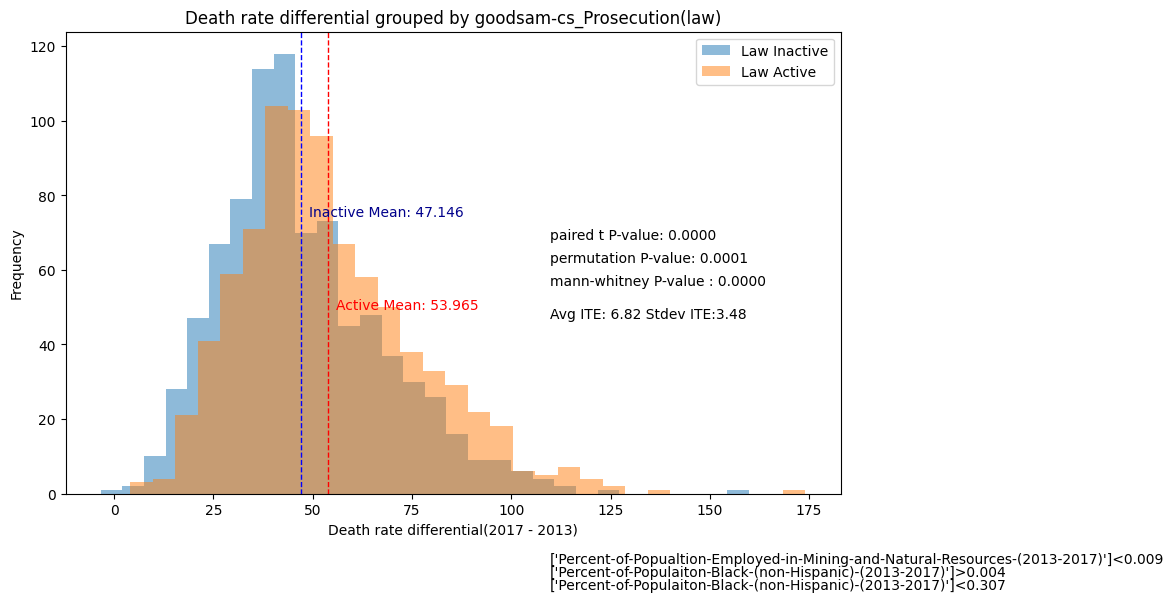

In [23]:

plt.figure(figsize=(10, 6))
plt.hist(predicted_Z0, bins=30, alpha=0.5, label='Law Inactive')
plt.hist(predicted_Z1, bins=30, alpha=0.5, label='Law Active')

plt.axvline(mean_law0, color='blue', linestyle='dashed', linewidth=1)
plt.text(mean_law0 + 2, plt.ylim()[1] * 0.6, f'Inactive Mean: {mean_law0:.3f}', color='darkblue')
plt.axvline(mean_law1, color='red', linestyle='dashed', linewidth=1)
plt.text(mean_law1 + 2, plt.ylim()[1] * 0.4, f'Active Mean: {mean_law1:.3f}', color='red')

plt.text(plt.xlim()[1]*0.6, plt.ylim()[1] * 0.45, f'mann-whitney P-value : {res_mannwhitneyu.pvalue:.4f}', color='black')
plt.text(plt.xlim()[1]*0.6, plt.ylim()[1] * 0.5, f'permutation P-value: {res_permute.pvalue:.4f}', color='black')
plt.text(plt.xlim()[1]*0.6, plt.ylim()[1] * 0.55, f'paired t P-value: {res_ttest.pvalue:.4f}', color='black')
plt.text(plt.xlim()[1]*0.6, plt.ylim()[1] * 0.38, f'Avg ITE: {avg_ite:.2f} Stdev ITE:{std_ite:.2f}', color='black', fontsize=10)

if len(conds) > 0:
    for i,cond in enumerate(conds):
        cond_text = cond[6:] 
        plt.text(plt.xlim()[1]*0.6, plt.ylim()[1] * -0.15 -3.5 * i, cond_text, color='black')


plt.xlabel('Death rate differential(2017 - 2013)')
plt.ylabel('Frequency')
plt.title('Death rate differential grouped by '+ law+'(law)')
plt.legend()
# plt.savefig("demo_res/sub_law_"+law+".png")
plt.show()